In [54]:
import warnings
warnings.simplefilter('ignore')

import os
import gc 
import sys
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb 

from tqdm import tqdm
from collections import defaultdict
from scipy.spatial import distance
from multiprocessing import cpu_count

from sklearn.model_selection import StratifiedKFold, KFold 
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

In [21]:
pd.options.display.max_columns = None

In [112]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# preprocess

In [113]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

In [114]:
test.insert(1, 'target', 0)

In [115]:
test.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,8.7625,-15.6305,18.8766,11.2864,11.8362,13.3680,-31.9891,12.1776,8.7714,17.2011,16.8508,13.0534,14.4069,-4.8525,7.3213,-0.5259,16.6365,19.3036,6.4129,-5.3948,9.3269,11.9314,-3.5750,-0.7706,0.8705,6.9282,2.8914,5.9744,17.4851,5.0125,-1.4230,33.3401,0.8018,-4.7906,30.2708,26.8339,21.7205,7.3075,14.0810,3.1192,17.4265,9.4883,16.9060,14.5117,10.0276,-0.9706,20.4588,4.7945,20.4160,13.1633,7.9307,-7.6509,7.0834,15.2324,10.1416,5.9156,-0.5775,5.7600,30.3238,2.1251,1.8585,-9.2198,17.3089,30.9548,1.4918,12.8721,3.4902,8.2856,11.9794,14.0176,15.0763,3.7662,6.0426,4.4243,14.1799,2.0921,1.5493,3.2206,0.0172,-6.6602,8.4785,42.0248,11.4164,0.4564,9.4006,0.9685,12.4929,14.1240,4.0388,-4.4442,16.6684,12.5380,0.9205,10.5998,7.5147,-4.1748,-0.4824,10.5267,17.7547,-6.5226,-2.5502,-5.1547,-2.1246,19.8319,13.0752,9.2275,3.0213,11.6793,-11.6827,4.1017,5.2954,18.7741,9.8892,7.5219,14.9745,18.9880,1.0842,11.9125,-4.5103,16.1361,11.0067,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,0,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,-1.5536,10.0309,3.1337,10.5742,11.7664,2.1782,-41.1924,13.5322,-17.3834,6.3806,12.5589,11.6887,25.3930,1.5776,6.8481,8.7348,16.4239,21.7056,6.9345,1.6678,9.5249,5.3383,-18.7083,1.3382,-1.7401,5.8398,3.1051,4.4307,16.0005,5.0306,-7.3365,12.2806,0.6992,-0.7772,21.5123,6.7803,18.1896,6.9388,22.1336,6.3755,13.1525,1.9772,14.0406,6.6904,9.9732,-11.5679,20.4525,9.4951,9.6343,8.1252,2.6059,-17.4201,7.1848,15.3484,10.6522,5.9897,0.3392,10.3516,29.8204,1.9998,-1.4166,-1.7257,15.4712,35.6020,1.6570,13.0783,2.7752,6.4986,4.6835,13.7963,17.7261,1.7375,5.5689,3.6609,8.9725,4.1159,1.0693,2.0234,8.2760,-6.8610,0.2780,17.0488,11.6704,3.1215,8.5093,5.6367,12.009

In [10]:
var_columns = [f'var_{i}' for i in range(0, 200)]

In [9]:
df = pd.concat([train, test], axis=0)

In [48]:
mms_df = df.copy()
ss_df = df.copy()

## MinMax

In [49]:
mms = MinMaxScaler()
mms_df[var_columns] = mms.fit_transform(df[var_columns])

## Standard

In [16]:
ss = StandardScaler()
ss_df[var_columns] = ss.fit_transform(df[var_columns])

## describe

In [18]:
mms_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,...,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,0.050245,0.473493,0.527827,0.498623,0.516504,0.517614,0.552122,0.512839,0.487632,0.522160,...,0.502300,0.522462,0.469955,0.502584,0.483082,0.522427,0.507413,0.467078,0.472879,0.532257
std,0.218450,0.137269,0.159136,0.153017,0.154819,0.139679,0.157906,0.138920,0.149120,0.161351,...,0.132230,0.155823,0.121078,0.132838,0.162979,0.145775,0.167543,0.145881,0.148714,0.153305
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.373179,0.406079,0.383653,0.399318,0.414964,0.428811,0.409834,0.374339,0.396706,...,0.406826,0.404654,0.384811,0.411422,0.360352,0.417595,0.376925,0.363441,0.372507,0.416232
50%,0.000000,0.466699,0.528871,0.490424,0.518872,0.519954,0.556623,0.509059,0.483374,0.527119,...,0.501418,0.518101,0.467508,0.505378,0.481614,0.519395,0.510785,0.463960,0.476301,0.539860
75%,0.000000,0.567413,0.644898,0.602707,0.632438,0.619319,0.672416,0.607883,0.599278,0.650610,...,0.594053,0.629291,0.553929,0.597861,0.607654,0.621533,0.637817,0.575485,0.580857,0.652563
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
ss_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,400000.000000,4.000000e+05,4.000000e+05,4.000000e+05,4.000000e+05,4.000000e+05,4.000000e+05,4.000000e+05,4.000000e+05,4.000000e+05,...,4.000000e+05,4.000000e+05,4.000000e+05,4.000000e+05,4.000000e+05,4.000000e+05,4.000000e+05,4.000000e+05,4.000000e+05,4.000000e+05
mean,0.050245,-2.643700e-16,-2.195744e-18,6.377576e-16,-7.879791e-16,1.107984e-15,1.934300e-16,-7.347678e-16,-3.405110e-17,6.525142e-17,...,-2.025302e-16,2.384148e-17,2.344805e-17,2.748561e-16,-8.259887e-16,1.667694e-17,7.366080e-17,-1.419941e-15,-5.297929e-16,-1.443415e-17
std,0.218450,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,0.000000,-3.449396e+00,-3.316829e+00,-3.258609e+00,-3.336174e+00,-3.705739e+00,-3.496534e+00,-3.691624e+00,-3.270060e+00,-3.236170e+00,...,-3.798688e+00,-3.352922e+00,-3.881439e+00,-3.783430e+00,-2.964076e+00,-3.583790e+00,-3.028562e+00,-3.201785e+00,-3.179804e+00,-3.471882e+00
25%,0.000000,-7.307891e-01,-7.650583e-01,-7.513572e-01,-7.569224e-01,-7.348989e-01,-7.809155e-01,-7.414728e-01,-7.597434e-01,-7.775203e-01,...,-7.220310e-01,-7.560376e-01,-7.032163e-01,-6.862673e-01,-7.530434e-01,-7.191376e-01,-7.788340e-01,-7.104284e-01,-6.749404e-01,-7.568227e-01
50%,0.000000,-4.949182e-02,6.558953e-03,-5.358401e-02,1.529691e-02,1.675131e-02,2.850624e-02,-2.721236e-02,-2.855547e-02,3.073859e-02,...,-6.673734e-03,-2.798683e-02,-2.020789e-02,2.103389e-02,-9.010985e-03,-2.079519e-02,2.012404e-02,-2.137595e-02,2.300735e-02,4.959887e-02
75%,0.000000,6.842098e-01,7.356636e-01,6.802097e-01,7.488326e-01,7.281343e-01,7.618149e-01,6.841601e-01,7.486971e-01,7.960931e-01,...,6.938886e-01,6.855810e-01,6.935605e-01,7.172366e-01,7.643404e-01,6.798557e-01,7.783324e-01,7.431162e-01,7.260800e-01,7.847521e-01
max,1.000000,3.835603e+00,2.967103e+00,3.276602e+00,3.122973e+00,3.453528e+00,2.836370e+00,3.506777e+00,3.435935e+00,2.961494e+00,...,3.763895e+00,3.064625e+00,4.377736e+00,3.744523e+00,3.171682e+00,3.276097e+00,2.940066e+00,3.653136e+00,3.544542e+00,3.051066e+00


## split

In [50]:
mms_train = mms_df.iloc[train.index]
mms_test = mms_df.iloc[test.index]

In [26]:
ss_train = ss_df.iloc[train.index]
ss_test = ss_df.iloc[test.index]

# EDA

<Figure size 432x288 with 0 Axes>

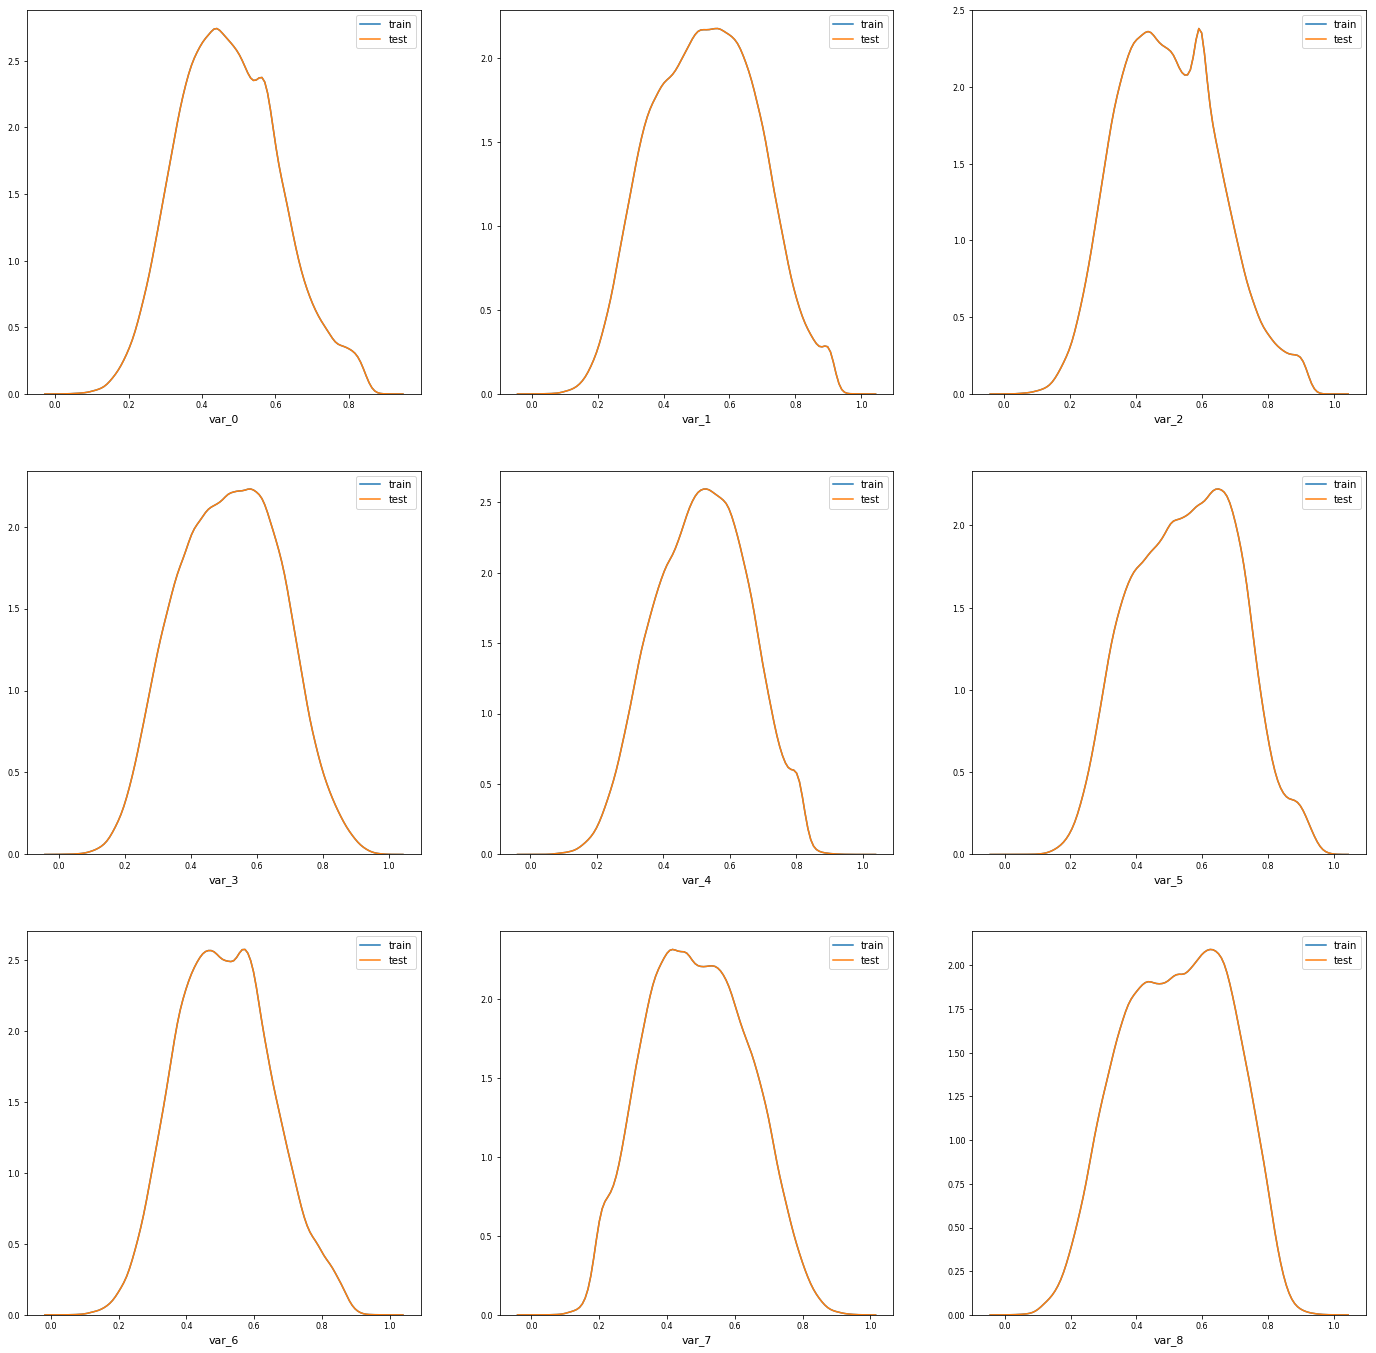

In [41]:
plt.figure()
fig, ax = plt.subplots(3, 3, figsize=(24, 24))

for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    sns.kdeplot(mms_train[f'var_{i}'], label='train')
    sns.kdeplot(mms_test[f'var_{i}'], label='test')
    plt.xlabel(f'var_{i}', fontsize=11)
    locs, labels = plt.xticks()
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)
plt.show()

## K-Means

### MinMax

In [51]:
for i in tqdm(range(2, 21)):
    km = KMeans(n_clusters=i, n_init=20, random_state=1, n_jobs=-1)
    km.fit(mms_train[var_columns]) 
    mms_train[f'minmax_cluster_{i}'] = km.predict(mms_train[var_columns]) 
    mms_test[f'minmax_cluster_{i}'] = km.predict(mms_test[var_columns]) 


100%|██████████| 19/19 [1:57:43<00:00, 371.78s/it]


<Figure size 432x288 with 0 Axes>

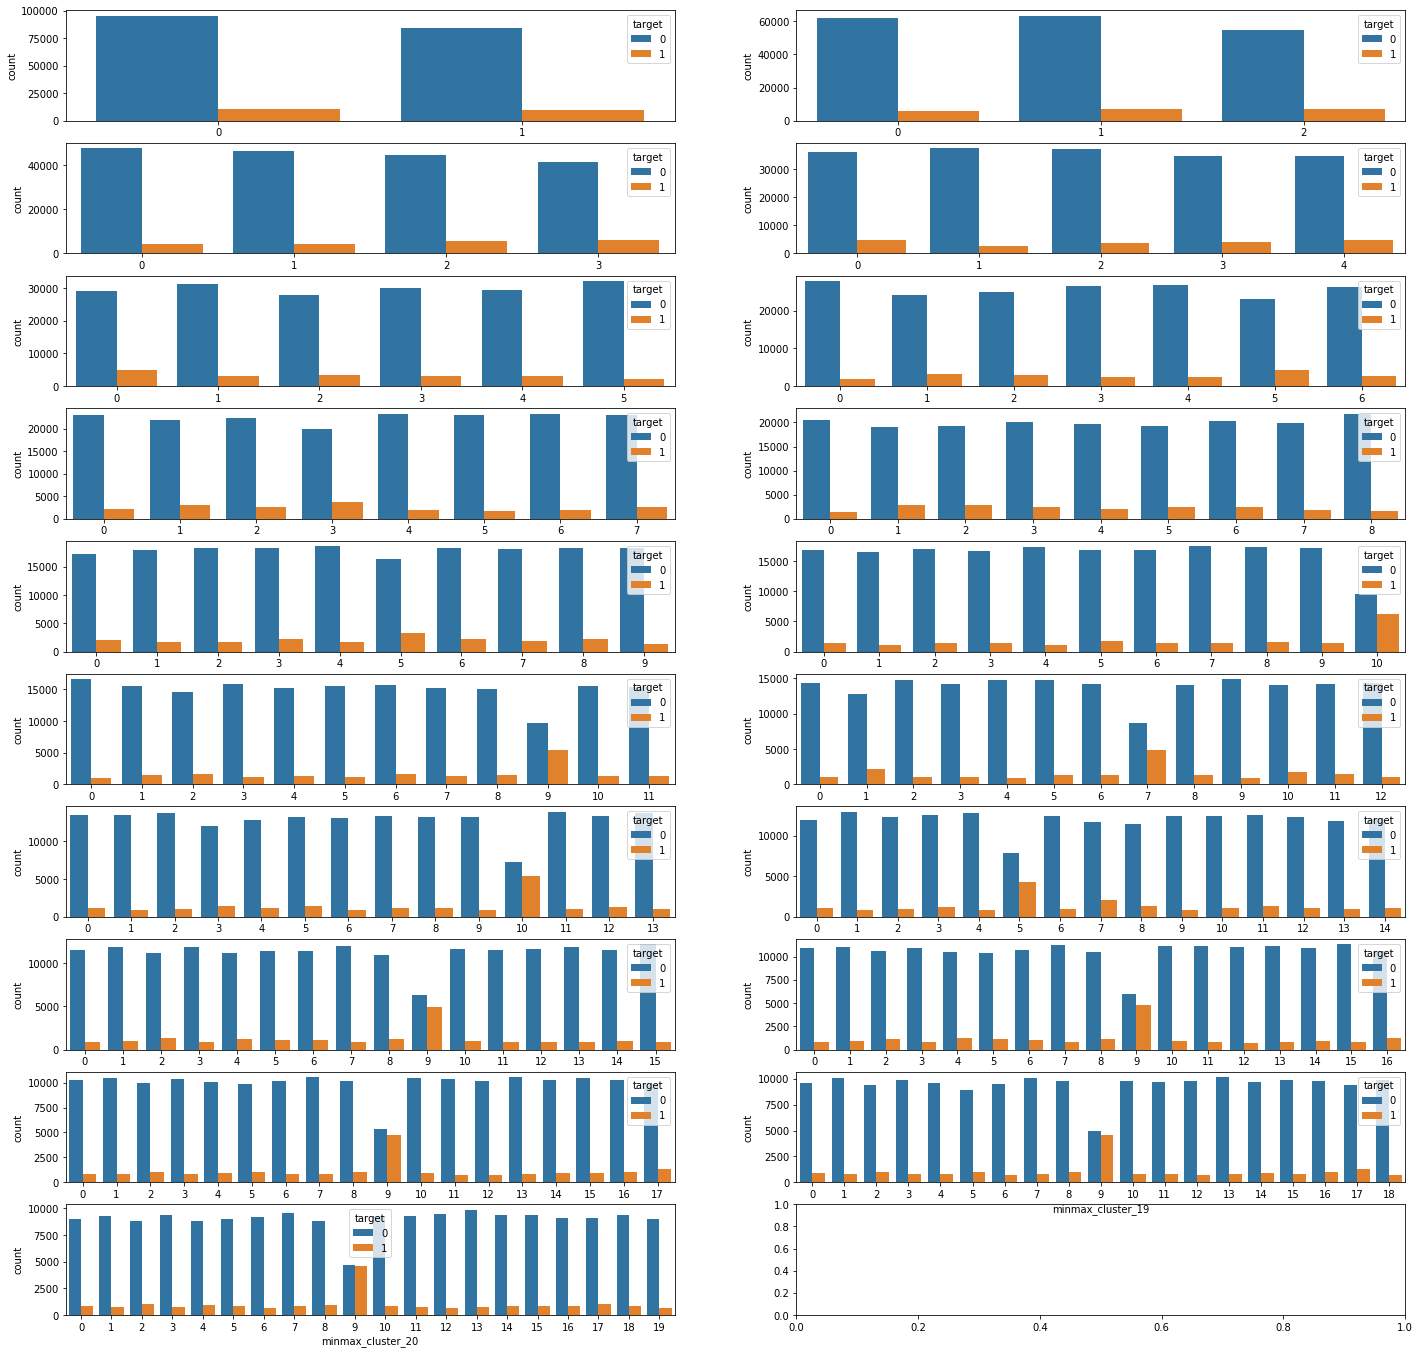

In [52]:
plt.figure()
fig, ax = plt.subplots(10, 2, figsize=(24, 24))

for i, j in enumerate(range(2, 21)):
    plt.subplot(10, 2, i+1)    
    sns.countplot(x=f'minmax_cluster_{j}', hue='target', data=mms_train)
plt.show()

In [89]:
mms_train_cluster_20 = mms_train.groupby(['minmax_cluster_20', 'target'])['ID_code'].count().reset_index()

In [90]:
mms_train_cluster_20_target_0 = mms_train_cluster_20.query('target == 0')
mms_train_cluster_20_target_1 = mms_train_cluster_20.query('target == 1')

In [91]:
mms_train_cluster_20_target_0.head()

,minmax_cluster_20,target,ID_code
0,0,0,8982
2,1,0,9321
4,2,0,8807
6,3,0,9403
8,4,0,8856


In [99]:
cluster = pd.DataFrame(mms_train_cluster_20_target_1['ID_code'].values / (mms_train_cluster_20_target_0['ID_code'].values + mms_train_cluster_20_target_1['ID_code'].values), columns=['rate'])

In [105]:
cluster.sort_values(by='rate', ascending=False).reset_index().rename(columns={'index': 'cluster'})

,cluster,rate
0,9,0.492768
1,17,0.103612
2,2,0.101051
3,8,0.096837
4,4,0.091879
5,0,0.088584
6,16,0.088223
7,5,0.085381
8,15,0.083031
9,14,0.082818


### Standard

In [45]:
for i in tqdm(range(2, 21)):
    km = KMeans(n_clusters=i, n_init=20, random_state=1, n_jobs=-1)
    km.fit(ss_train[var_columns]) 
    ss_train[f'standard_cluster_{i}'] = km.predict(ss_train[var_columns]) 
    ss_test[f'standard_cluster_{i}'] = km.predict(ss_test[var_columns]) 

100%|██████████| 19/19 [2:15:23<00:00, 427.54s/it]


<Figure size 432x288 with 0 Axes>

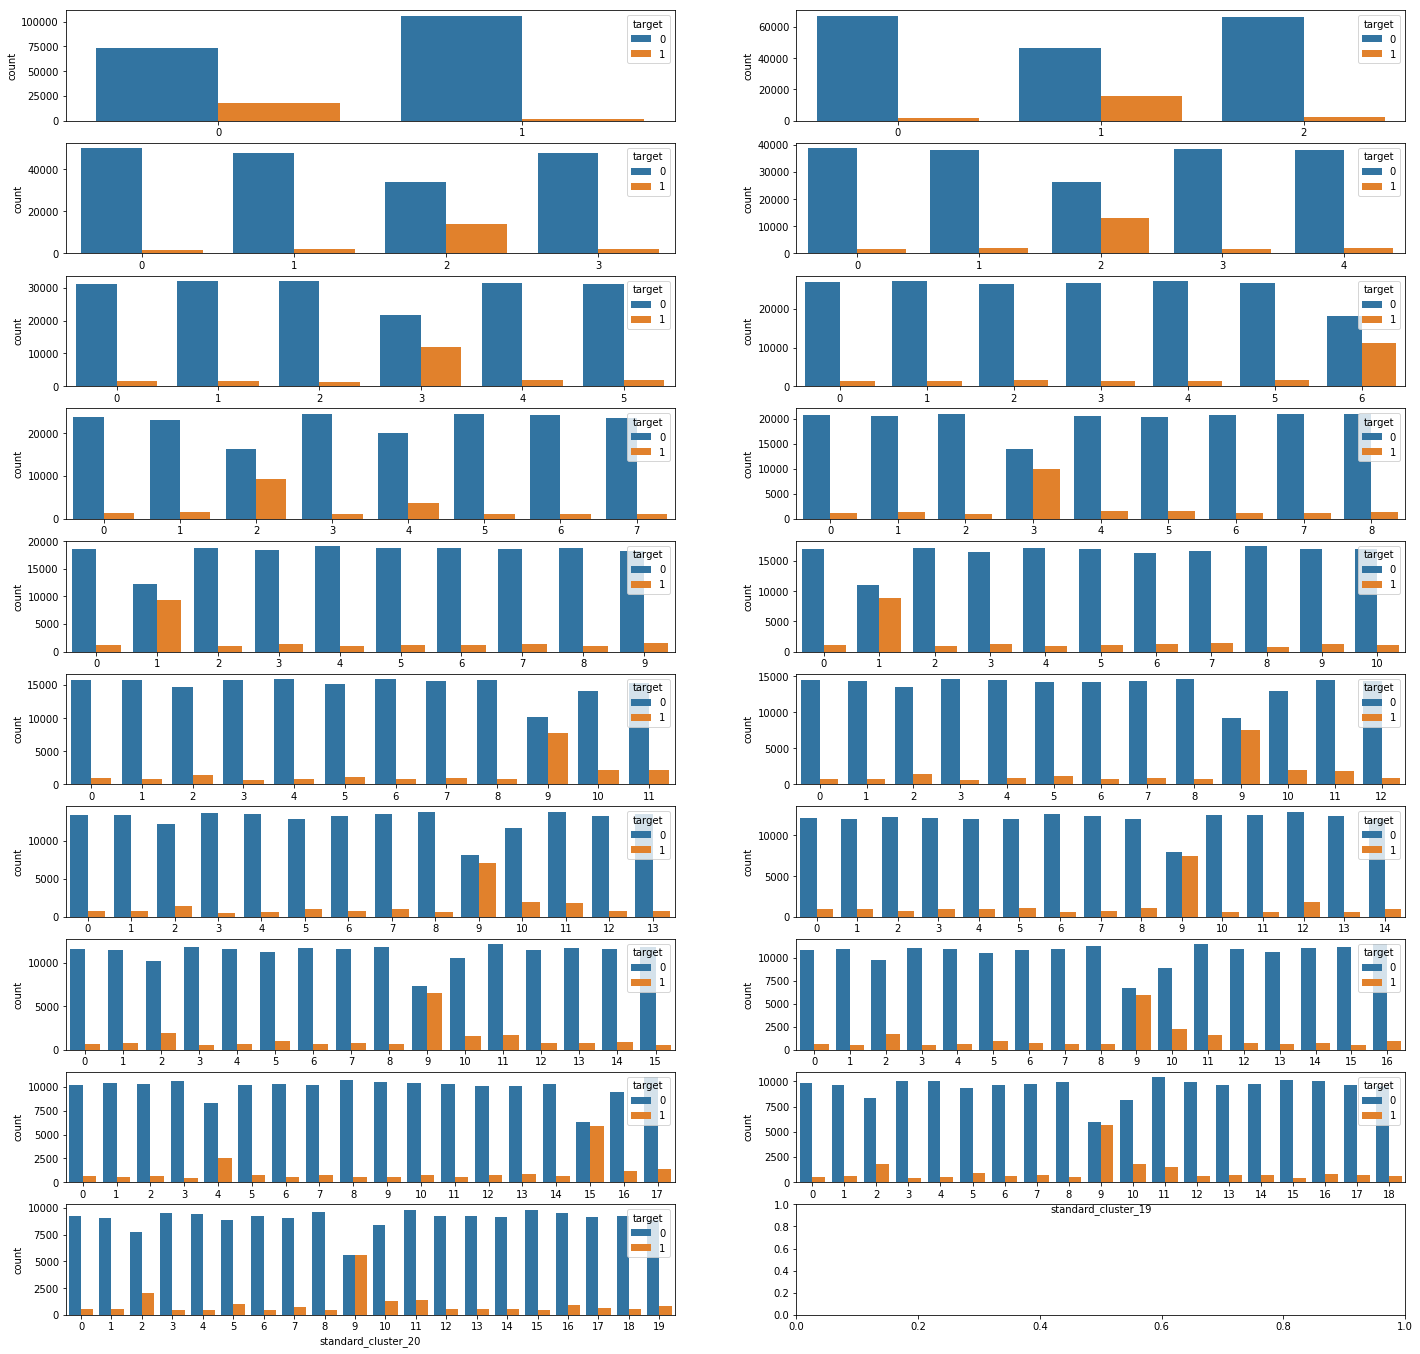

In [53]:
plt.figure()
fig, ax = plt.subplots(10, 2, figsize=(24, 24))

for i, j in enumerate(range(2, 21)):
    plt.subplot(10, 2, i+1)    
    sns.countplot(x=f'standard_cluster_{j}', hue='target', data=ss_train)
plt.show()

In [79]:
ss_train.groupby(['standard_cluster_2', 'target'])['ID_code'].count().reset_index()

,standard_cluster_2,target,ID_code
0,0,0,73798
1,0,1,17931
2,1,0,106104
3,1,1,2167


In [80]:
ss_train.groupby(['standard_cluster_3', 'target'])['ID_code'].count().reset_index()

,standard_cluster_3,target,ID_code
0,0,0,67151
1,0,1,2108
2,1,0,46530
3,1,1,15742
4,2,0,66221
5,2,1,2248


In [81]:
ss_train.groupby(['standard_cluster_4', 'target'])['ID_code'].count().reset_index()

,standard_cluster_4,target,ID_code
0,0,0,50051
1,0,1,1749
2,1,0,47934
3,1,1,2055
4,2,0,34016
5,2,1,14067
6,3,0,47901
7,3,1,2227


In [82]:
ss_train.groupby(['standard_cluster_5', 'target'])['ID_code'].count().reset_index()

,standard_cluster_5,target,ID_code
0,0,0,38719
1,0,1,1646
2,1,0,37981
3,1,1,2004
4,2,0,26423
5,2,1,12953
6,3,0,38571
7,3,1,1609
8,4,0,38208
9,4,1,1886


In [83]:
ss_train.groupby(['standard_cluster_6', 'target'])['ID_code'].count().reset_index()

,standard_cluster_6,target,ID_code
0,0,0,31242
1,0,1,1699
2,1,0,32083
3,1,1,1461
4,2,0,32188
5,2,1,1211
6,3,0,21863
7,3,1,11995
8,4,0,31413
9,4,1,1853


In [84]:
ss_train.groupby(['standard_cluster_7', 'target'])['ID_code'].count().reset_index()

,standard_cluster_7,target,ID_code
0,0,0,26913
1,0,1,1459
2,1,0,27257
3,1,1,1405
4,2,0,26512
5,2,1,1704
6,3,0,26852
7,3,1,1438
8,4,0,27309
9,4,1,1360


In [85]:
ss_train.groupby(['standard_cluster_8', 'target'])['ID_code'].count().reset_index()

,standard_cluster_8,target,ID_code
0,0,0,23724
1,0,1,1260
2,1,0,22975
3,1,1,1522
4,2,0,16394
5,2,1,9316
6,3,0,24446
7,3,1,1071
8,4,0,19925
9,4,1,3598


In [86]:
ss_train.groupby(['standard_cluster_9', 'target'])['ID_code'].count().reset_index()

,standard_cluster_9,target,ID_code
0,0,0,20781
1,0,1,1087
2,1,0,20605
3,1,1,1354
4,2,0,21014
5,2,1,1053
6,3,0,13975
7,3,1,9938
8,4,0,20598
9,4,1,1481


In [109]:
ss_train_cluster_20 = ss_train.groupby(['standard_cluster_2', 'target'])['ID_code'].count().reset_index()
ss_train_cluster_20_target_0 = ss_train_cluster_20.query('target == 0')
ss_train_cluster_20_target_1 = ss_train_cluster_20.query('target == 1')

cluster = pd.DataFrame(ss_train_cluster_20_target_1['ID_code'].values / (ss_train_cluster_20_target_0['ID_code'].values + ss_train_cluster_20_target_1['ID_code'].values), columns=['rate'])
cluster.sort_values(by='rate', ascending=False).reset_index().rename(columns={'index': 'cluster'})

,cluster,rate
0,0,0.195478
1,1,0.020015


In [108]:
ss_train_cluster_20 = ss_train.groupby(['standard_cluster_10', 'target'])['ID_code'].count().reset_index()
ss_train_cluster_20_target_0 = ss_train_cluster_20.query('target == 0')
ss_train_cluster_20_target_1 = ss_train_cluster_20.query('target == 1')

cluster = pd.DataFrame(ss_train_cluster_20_target_1['ID_code'].values / (ss_train_cluster_20_target_0['ID_code'].values + ss_train_cluster_20_target_1['ID_code'].values), columns=['rate'])
cluster.sort_values(by='rate', ascending=False).reset_index().rename(columns={'index': 'cluster'})

,cluster,rate
0,1,0.430735
1,9,0.074029
2,3,0.071588
3,7,0.071418
4,5,0.061772
5,6,0.057356
6,0,0.056376
7,8,0.051811
8,2,0.050704
9,4,0.049624


In [107]:
ss_train_cluster_20 = ss_train.groupby(['standard_cluster_20', 'target'])['ID_code'].count().reset_index()
ss_train_cluster_20_target_0 = ss_train_cluster_20.query('target == 0')
ss_train_cluster_20_target_1 = ss_train_cluster_20.query('target == 1')

cluster = pd.DataFrame(ss_train_cluster_20_target_1['ID_code'].values / (ss_train_cluster_20_target_0['ID_code'].values + ss_train_cluster_20_target_1['ID_code'].values), columns=['rate'])
cluster.sort_values(by='rate', ascending=False).reset_index().rename(columns={'index': 'cluster'})

,cluster,rate
0,9,0.500494
1,2,0.208684
2,10,0.130859
3,11,0.120771
4,5,0.102367
5,19,0.087842
6,16,0.085080
7,7,0.073020
8,17,0.069595
9,14,0.060407


# PCA, TruncatedSVD, t-SNE

## PCA

In [56]:
pca = PCA(n_components=2)
pca_mms_train = pca.fit_transform(mms_train[var_columns])
mms_train['pca_0'] = pca_mms_train[:, 0]
mms_train['pca_1'] = pca_mms_train[:, 1]

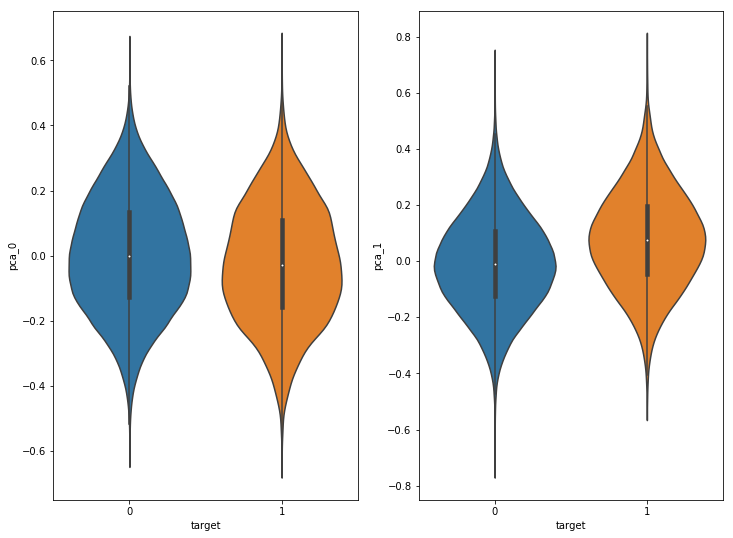

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(12, 9))

for i in range(0, 2):
    plt.subplot(1, 2, i+1)
    sns.violinplot(x='target', y=f'pca_{i}', data=mms_train)
plt.show()

In [55]:
pca = PCA(n_components=2)
pca_ss_train = pca.fit_transform(ss_train[var_columns])
ss_train['pca_0'] = pca_ss_train[:, 0]
ss_train['pca_1'] = pca_ss_train[:, 1]

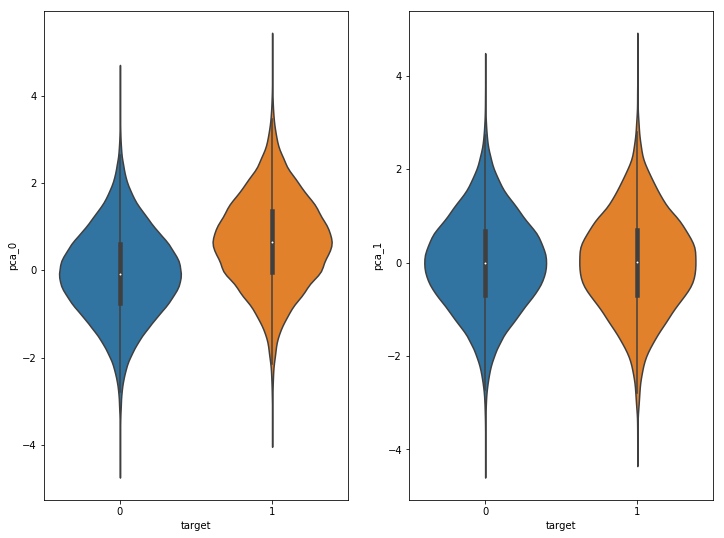

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(12, 9))

for i in range(0, 2):
    plt.subplot(1, 2, i+1)
    sns.violinplot(x='target', y=f'pca_{i}', data=ss_train)
plt.show()

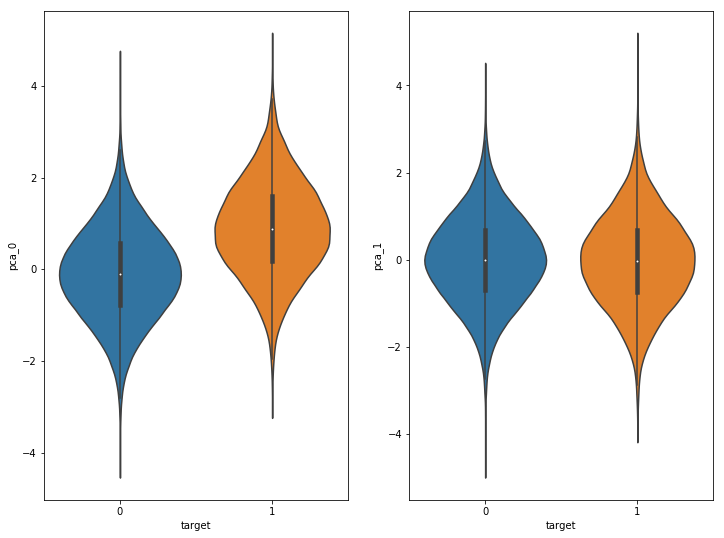

In [120]:
pca = PCA(n_components=2)
pca_train = pca.fit_transform(ss_train[var_columns])
train['pca_0'] = pca_train[:, 0]
train['pca_1'] = pca_train[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(12, 9))

for i in range(0, 2):
    plt.subplot(1, 2, i+1)
    sns.violinplot(x='target', y=f'pca_{i}', data=train)
plt.show()

## TruncatedSVD

In [65]:
tsvd = TruncatedSVD(n_components=2)
tsvd_mms_train = tsvd.fit_transform(mms_train[var_columns])
mms_train['tsvd_0'] = tsvd_mms_train[:, 0]
mms_train['tsvd_1'] = tsvd_mms_train[:, 1]

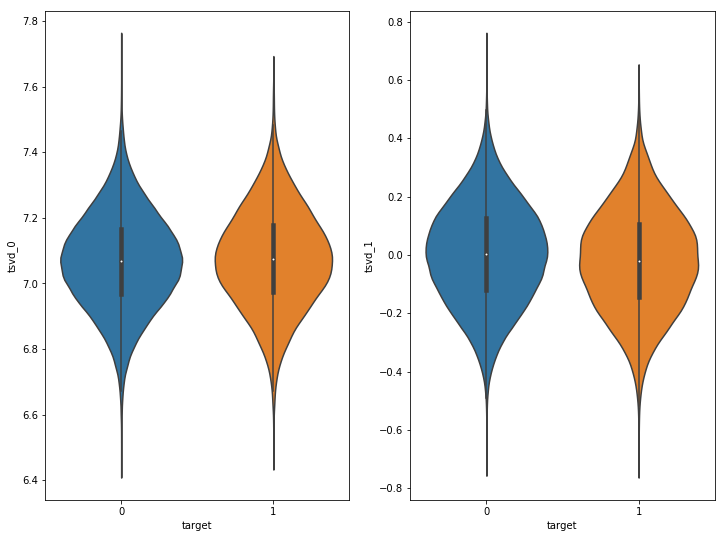

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(12, 9))

for i in range(0, 2):
    plt.subplot(1, 2, i+1)
    sns.violinplot(x='target', y=f'tsvd_{i}', data=mms_train)
plt.show()

In [67]:
tsvd = TruncatedSVD(n_components=2)
tsvd_ss_train = tsvd.fit_transform(ss_train[var_columns])
ss_train['tsvd_0'] = tsvd_ss_train[:, 0]
ss_train['tsvd_1'] = tsvd_ss_train[:, 1]

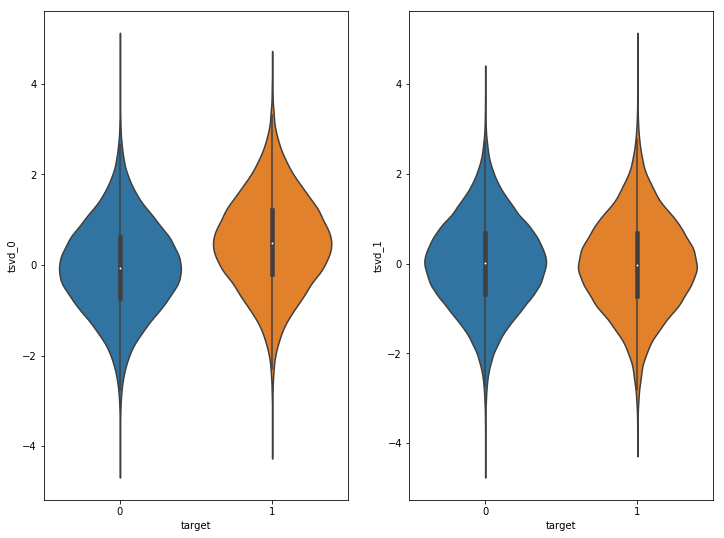

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(12, 9))

for i in range(0, 2):
    plt.subplot(1, 2, i+1)
    sns.violinplot(x='target', y=f'tsvd_{i}', data=ss_train)
plt.show()

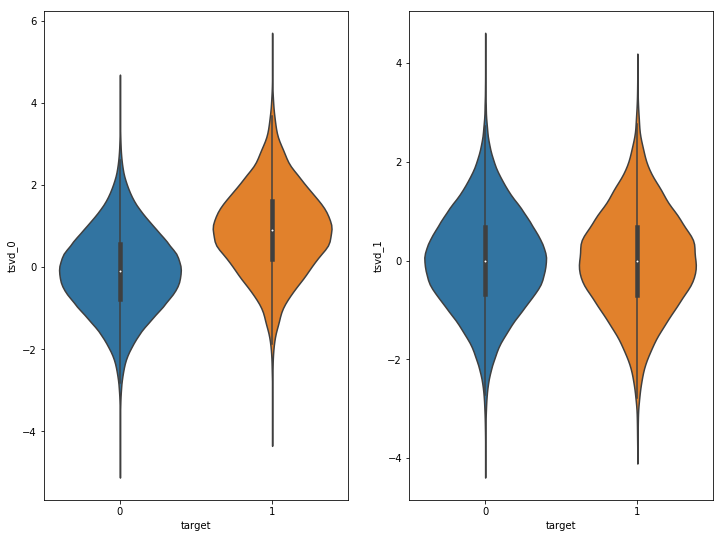

In [119]:
tsvd = TruncatedSVD(n_components=2)
tsvd_train = tsvd.fit_transform(ss_train[var_columns])
train['tsvd_0'] = tsvd_train[:, 0]
train['tsvd_1'] = tsvd_train[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(12, 9))

for i in range(0, 2):
    plt.subplot(1, 2, i+1)
    sns.violinplot(x='target', y=f'tsvd_{i}', data=train)
plt.show()

## t-SNE

In [69]:
tsne = TSNE(n_components=2)
tsne_mms_train = tsvd.fit_transform(mms_train[var_columns])
mms_train['tsne_0'] = tsvd_mms_train[:, 0]
mms_train['tsne_1'] = tsvd_mms_train[:, 1]

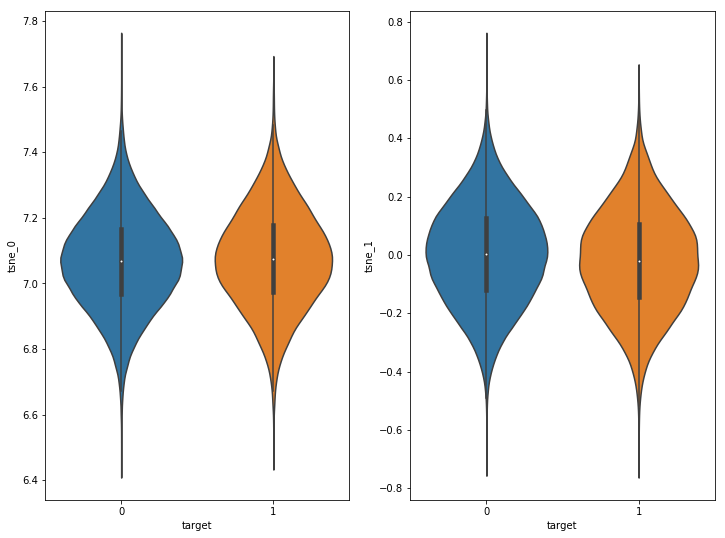

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(12, 9))

for i in range(0, 2):
    plt.subplot(1, 2, i+1)
    sns.violinplot(x='target', y=f'tsne_{i}', data=mms_train)
plt.show()

In [74]:
tsne = TSNE(n_components=2)
tsne_ss_train = tsvd.fit_transform(ss_train[var_columns])
ss_train['tsne_0'] = tsvd_ss_train[:, 0]
ss_train['tsne_1'] = tsvd_ss_train[:, 1]

In [121]:
tsne = TSNE(n_components=2)
result = tsvd.fit_transform(df[var_columns])

In [124]:
result

array([[149.59330689,  -6.32536525],
       [152.99420175,  34.10516557],
       [135.54183772,  -3.9805258 ],
       ...,
       [139.48997913,   6.34439632],
       [146.50456572,  27.15994371],
       [153.19957481,   8.29475069]])

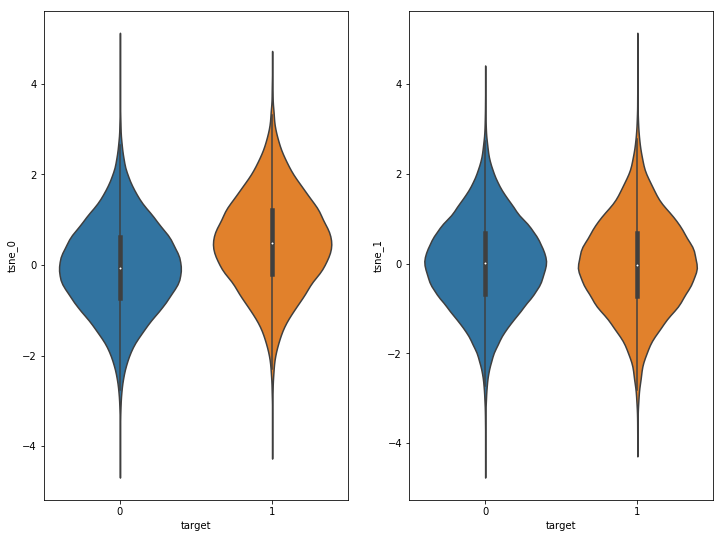

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(12, 9))

for i in range(0, 2):
    plt.subplot(1, 2, i+1)
    sns.violinplot(x='target', y=f'tsne_{i}', data=ss_train)
plt.show()

In [117]:
tsne = TSNE(n_components=2)
tsne_train = tsvd.fit_transform(ss_train[var_columns])
train['tsne_0'] = tsne_train[:, 0]
train['tsne_1'] = tsne_train[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(12, 9))

for i in range(0, 2):
    plt.subplot(1, 2, i+1)
    sns.violinplot(x='target', y=f'tsne_{i}', data=train)
plt.show()

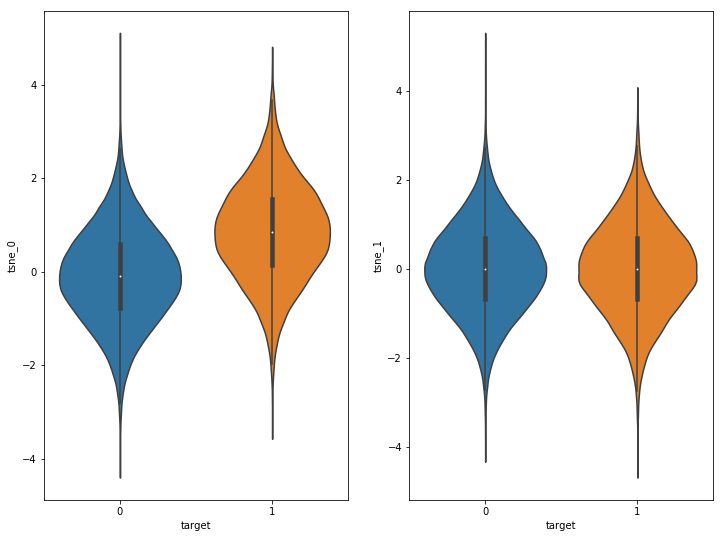

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(12, 9))

for i in range(0, 2):
    plt.subplot(1, 2, i+1)
    sns.violinplot(x='target', y=f'tsne_{i}', data=train)
plt.show()